# Integrated Gradients
Integrated Gradients is a technique for attributing a classification model's prediction to its input features. It is a model interpretability technique: you can use it to visualize the relationship between input features and model predictions.

Integrated Gradients is a variation on computing the gradient of the prediction output with regard to features of the input. To compute integrated gradients, we need to perform the following steps:

Identify the input and the output. In our case, the input is an image and the output is the last layer of our model (dense layer with softmax activation).

Compute which features are important to a neural network when making a prediction on a particular data point. To identify these features, we need to choose a baseline input. A baseline input can be a black image (all pixel values set to zero) or random noise. The shape of the baseline input needs to be the same as our input image, e.g. (299, 299, 3).

Interpolate the baseline for a given number of steps. The number of steps represents the steps we need in the gradient approximation for a given input image. The number of steps is a hyperparameter. The authors recommend using anywhere between 20 and 1000 steps.

Preprocess these interpolated images and do a forward pass.

Get the gradients for these interpolated images.
Approximate the gradients integral using the trapezoidal rule.
To read in-depth about integrated gradients and why this method works, consider reading this excellent [article](https://distill.pub/2020/attribution-baselines/).

- **Paper**: Axiomatic Attribution for Deep Networks [ [pdf](https://arxiv.org/pdf/1703.01365.pdf) ]
- **Keras Code Example**: https://keras.io/examples/vision/integrated_gradients/
- **Original implementation**: https://github.com/ankurtaly/Integrated-Gradients


# TIL

- opening & closing : [link](https://swprog.tistory.com/entry/Mathematical-morphology-%EB%AA%A8%ED%8F%B4%EB%A1%9C%EC%A7%80-%EC%97%B0%EC%82%B0)

- binary_fill_holes : [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_fill_holes.html)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image

import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.models import resnext101_32x8d
from torchvision import transforms

from urllib.request import urlretrieve
import json

In [2]:
class Config:
    img_size = (299, 299, 3)
    img_path = './data/elephant.jpg'
    imagenet_class_idx = json.load(open('./imagenet_class_index.json','r'))
config = Config()

In [3]:
img_path = urlretrieve('http://i.imgur.com/Bvro0YD.png',config.img_path)

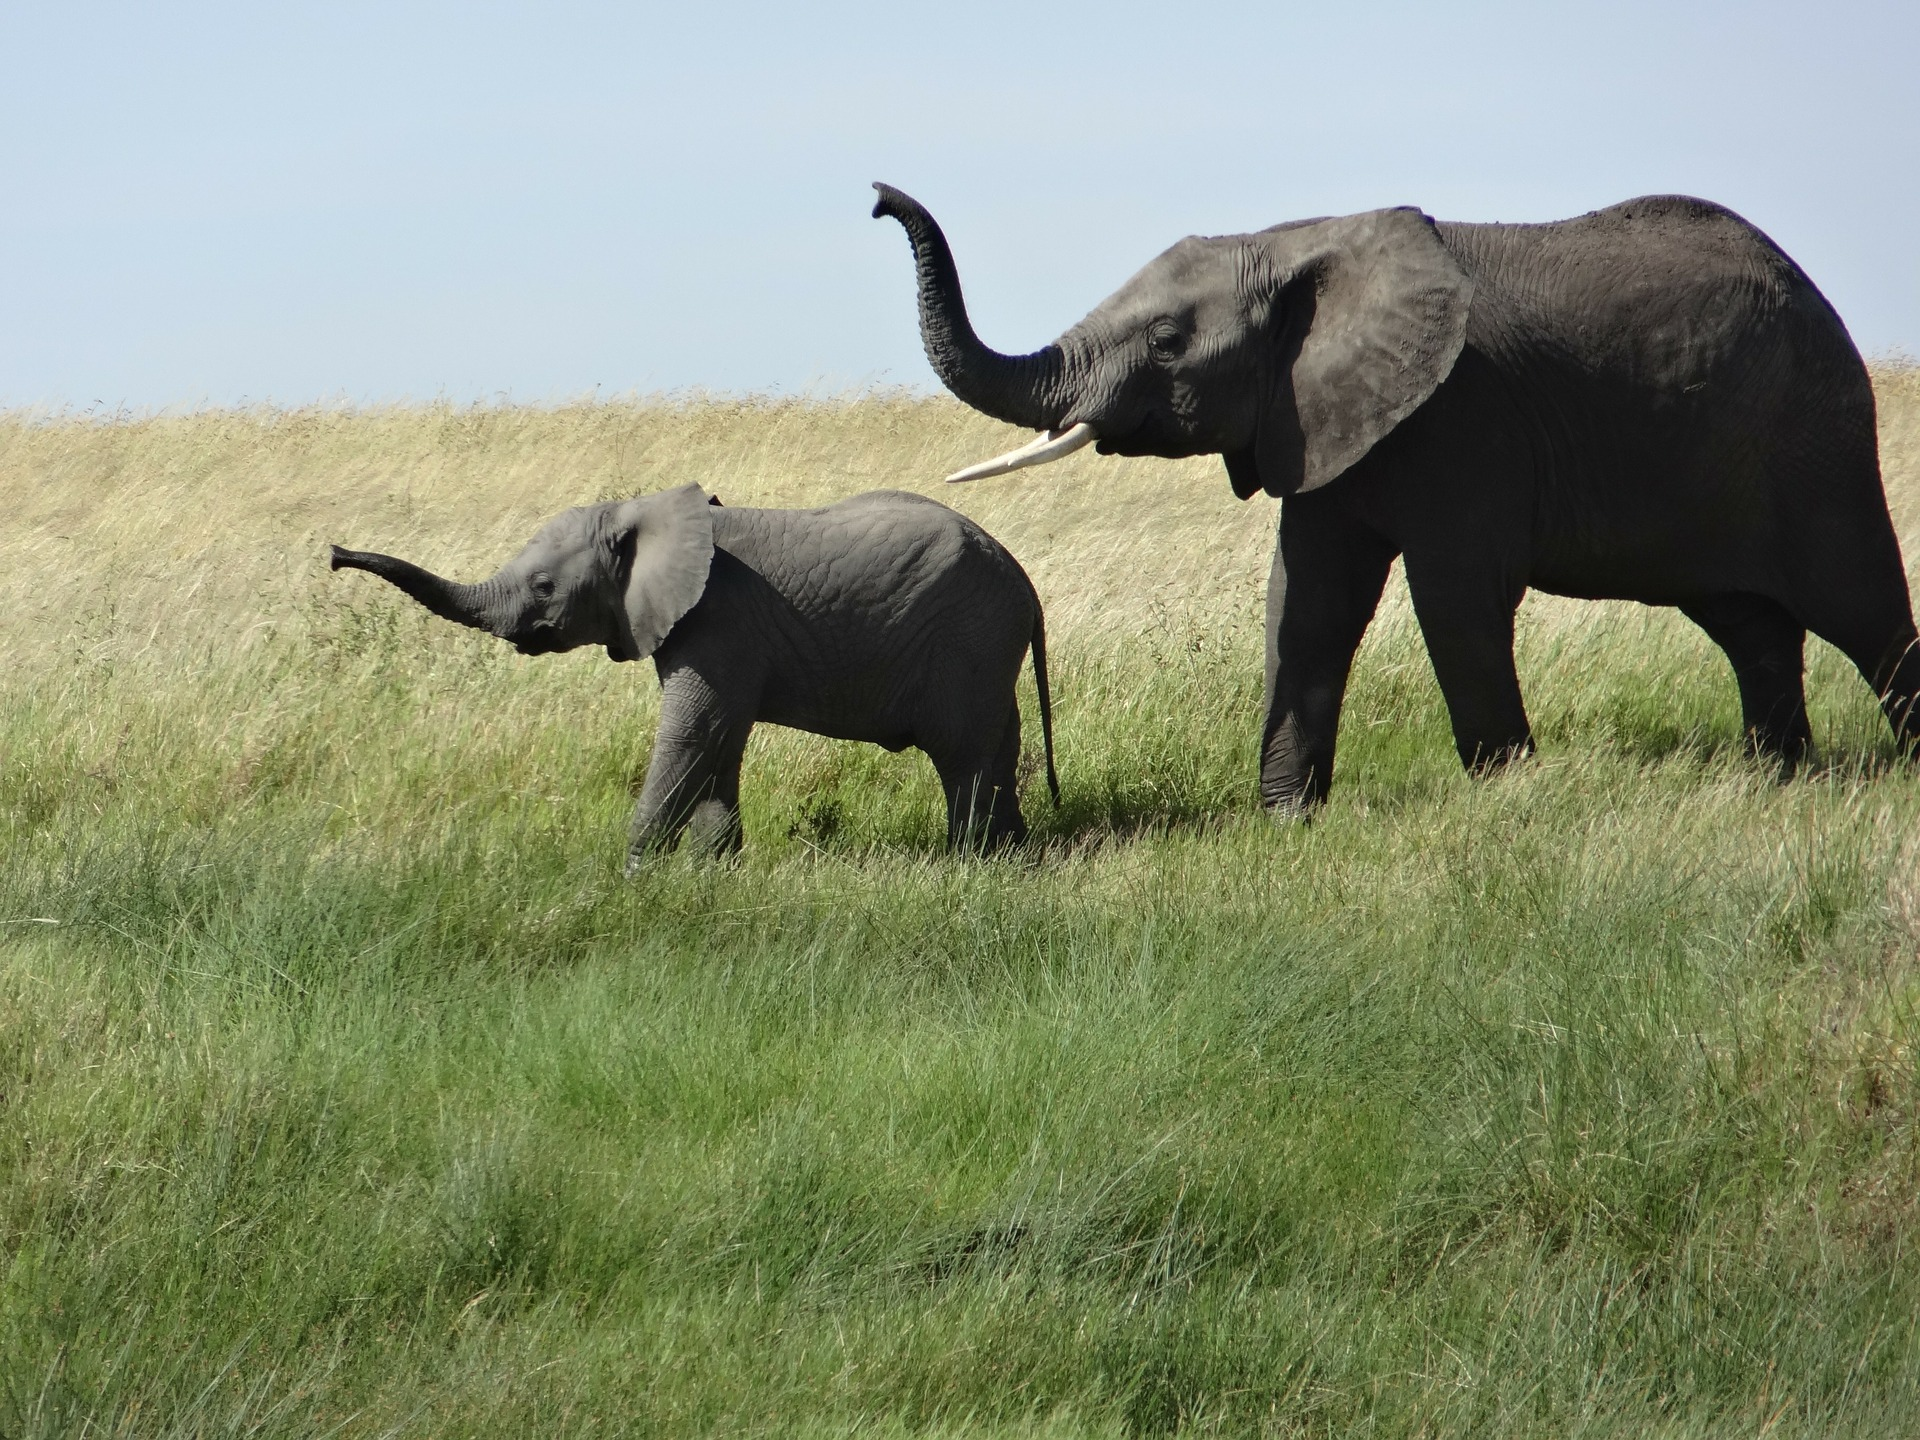

In [4]:
Image.open(config.img_path)

# Integrated Gradients algorithm

![image](https://user-images.githubusercontent.com/37654013/128622064-6faea356-e946-4028-bcfe-bce45a3acb57.png)


In [5]:
def get_img_array(img_path, size=(299, 299)):
    img = Image.open(img_path).convert("RGB").resize(size)
    array = np.array(img)
    
    return array

In [6]:
def preprocessing_image(arr):
#     totensor = transforms.ToTensor()
#     arr = totensor(arr)
    arr = torch.FloatTensor(arr).permute(2,0,1) / 255.
    arr = arr.unsqueeze(0)
    
    return arr

In [7]:
class IntegratedGradients(object):
    '''
    Integrated Gradients
    '''
    def __init__(self, model, **kwargs):
        self.model = model
        # evaluation mode
        self.model.eval()


    def generate_images_on_linear_path(self, input_images, steps, baseline):
        # divide image by step list
        step_list = np.arange(steps+1)/steps
        xbar_list = [(input_images-baseline)*step for step in step_list]
        return xbar_list 

    def generate_gradients(self, pre_imgs, targets, **kwargs):
        # prediction
        pre_imgs = Variable(pre_imgs, requires_grad=True)
        outputs = self.model(pre_imgs)
        
        # calculate gradients
        self.model.zero_grad()

        one_hot_output = torch.zeros_like(outputs).scatter(1, targets.unsqueeze(1), 1).detach()
        outputs.backward(gradient=one_hot_output)
        probs, preds = outputs.detach().max(1)

        imgs = pre_imgs.grad.numpy()

        return imgs

    def generate_image(self, pre_imgs, targets, baseline=None, **kwargs):
        # baseline
        if baseline is None:
            baseline = np.zeros(pre_imgs.size()).astype(np.float32)
        else:
            baseline = baseline.astype(np.float32)
            
        # default
        steps = 10 if 'steps' not in kwargs.keys() else kwargs['steps']

        # convert target type to LongTensor
        targets = torch.LongTensor(targets)

        # divide image
        xbar_list = self.generate_images_on_linear_path(pre_imgs, steps, baseline)
        avg_grads = np.zeros(pre_imgs.size())

        # make saliency map from divided images
        for xbar_image in xbar_list:
            grads = self.generate_gradients(xbar_image, targets)
            avg_grads += grads/steps
        
        # rescale saliency map
        sal_maps = (pre_imgs - baseline) * avg_grads 
        
        return sal_maps

In [8]:
def random_baseline_integrated_gradients(
    IG, img_input, top_pred_idx, num_steps=50, num_runs=2
):
    integrated_grads = []
    
    for run in range(num_runs):
        baseline = np.random.random(img_input.shape)
        igrads = IG.generate_image(
            pre_imgs=img_input,
            targets=top_pred_idx,
            steps=num_steps
        )
        integrated_grads.append(igrads.numpy())
        
    integrated_grads = torch.as_tensor(integrated_grads)
    
    return integrated_grads.mean(axis=0)

# Helper class for visualizing gradients and integrated gradients

In [9]:
class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        gradients,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img1 = np.copy(image)
        img2 = np.copy(image)

        # 2. Process the normal gradients
        grads_attr = self.process_grads(
            image=img1,
            attributions=gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 3, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(grads_attr.astype(np.uint8))
        ax[2].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Normal gradients")
        ax[2].set_title("Integrated gradients")
        plt.show()

# Let's test-drive it

In [10]:
arr = get_img_array(img_path=config.img_path)
pre_arr = preprocessing_image(arr=arr)

In [11]:
model = resnext101_32x8d(pretrained=True)
np.sum([np.prod([p.size()]) for p in model.parameters()])

88791336

In [12]:
model.eval()
output = model(pre_arr)
output = nn.functional.softmax(output,dim=1)

In [13]:
prob, pred = output.max(1)

In [14]:
IG = IntegratedGradients(model=model)

In [15]:
grads = IG.generate_gradients(pre_imgs=pre_arr, targets=pred)
igrads = random_baseline_integrated_gradients(IG,
                                              img_input=pre_arr, 
                                              top_pred_idx=pred,
                                              num_steps=50,
                                              num_runs=2)


In [16]:
print('class name: ',config.imagenet_class_idx[f'{pred.item()}'])
print(f"probability: {prob.item():.4%}")
print(f"predict index: {pred.item()}")

class name:  ['n02504458', 'African_elephant']
probability: 89.8476%
predict index: 386


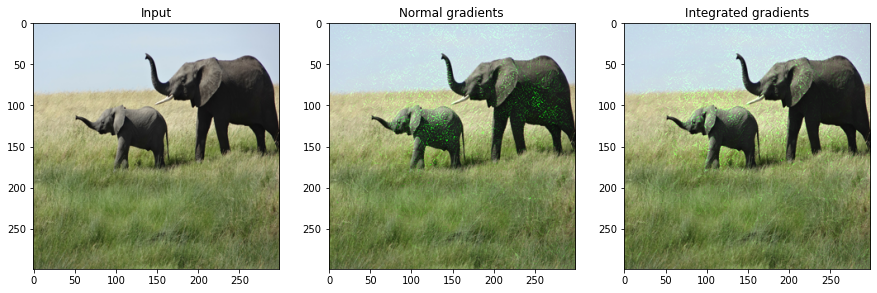

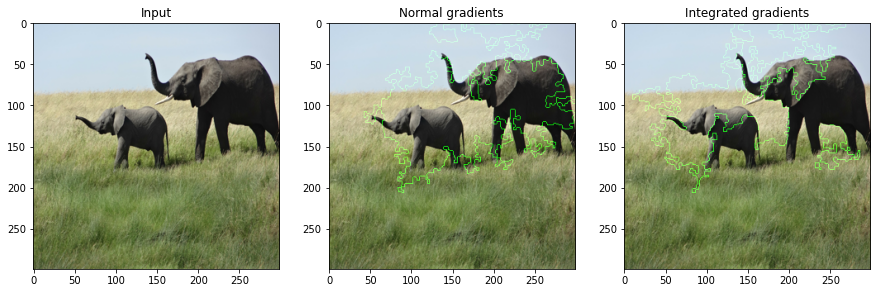

In [18]:
vis = GradVisualizer()
vis.visualize(
    image=arr,
    gradients=np.transpose(grads[0], axes=[1,2,0]),
    integrated_gradients=igrads[0].permute(1,2,0).numpy(),
    clip_above_percentile=99,
    clip_below_percentile=0,
)

vis.visualize(
    image=arr,
    gradients=np.transpose(grads[0], axes=[1,2,0]),
    integrated_gradients=igrads[0].permute(1,2,0).numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
    morphological_cleanup=True,
    outlines=True,
)